# Maximum Likelihood Estimation and Limited Dependent Variable Models

*Monday 23, September*

### Content

- [1. Short intro to MLE](#1.-Short-intro-to-MLE)
- [2. Coding the MLE estimator](#2.-Coding-the-MLE-estimator)
- [3. MLE with 'statsmodels'](#3.-MLE-with-'statsmodels')
- [4. LDV with 'statsmodels']()

### 1. Short intro to MLE



Maximum likelihood is an intuitive and popular method of statistical inference. It involves choosing a set of parameters such that, when fed to a Data Generating Process (DGP), they match the observed moments of the data. The main advantages of maximum likelihood estimation are:
* its efficiency: It achieves the **Cramer-Rao** lower bound when $n \rightarrow \infty$
* its consistency: The ML estimator converges in probability to the true parameter $\hat{\theta}_{MLE} \xrightarrow{p} \theta$, and even almost surely under stricter regularity conditions
* its versatility: Any DGP can be estimated by MLE. It is more versatile than linear regression as it allows for more intricate relationships between variables.

Its main drawback is that it requires us to assume a specific parametric distribution of the data.

### 2. Coding the MLE estimator 

#### 2.1. The linear case

Let's create a random sample of size $N = 1,000$, generated by the following DGP: $$ \mathbf{y} = \mathbf{X \beta} + \mathbf{\varepsilon} \\ \varepsilon \sim \mathcal{N}(0, \sigma^2 I)$$
The normality of errors and their 0-correlation ensure they are independent, a property we will use when implementing the MLE method.

In [13]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mp
%matplotlib nbagg
import matplotlib.pyplot as plt

import statsmodels as sm

In [14]:
# True values of X's will be linear functions measured without noise
X1_true = np.linspace(0, 100, 1000) 
X2_true = np.linspace(0, -500, 1000) 
X3_true = np.linspace(0, 2000, 1000) 

# We also add a vector of ones to the matrix of observables, this will allow us to include an intercept in the model
X0 = np.ones(1000)

X_true = np.array([X0,
              X1_true, 
              X2_true,
              X3_true]).T

# We define observed covariates as the sum of the true X's + normal noise (can be interpreted as measurement error or simply as a way to avoid perfect multicolinearity) 
X1 = X1_true + np.random.normal(loc=0.0, scale = 10, size=1000)
X2 = X2_true + np.random.normal(loc=0.0, scale = 50, size=1000) 
X3 = X3_true + np.random.normal(loc=0.0, scale = 200, size=1000)

X = np.array([X0,
              X1, 
              X2,
              X3]).T

# True parameters
β = np.array([5, 10, -.5, .25]).T
sigma = 100
epsilon = np.random.normal(loc=0.0, scale = sigma, size=1000)

# Measured and true values
y = X @ β + epsilon
y_true = X_true @ β

We get a simple linear, homoskedastic relastionship between the covariates and the observed $y_i$. See for instance $\mathbf{y}$ with respect to $\mathbf{x_1}$ below

<IPython.core.display.Javascript object>


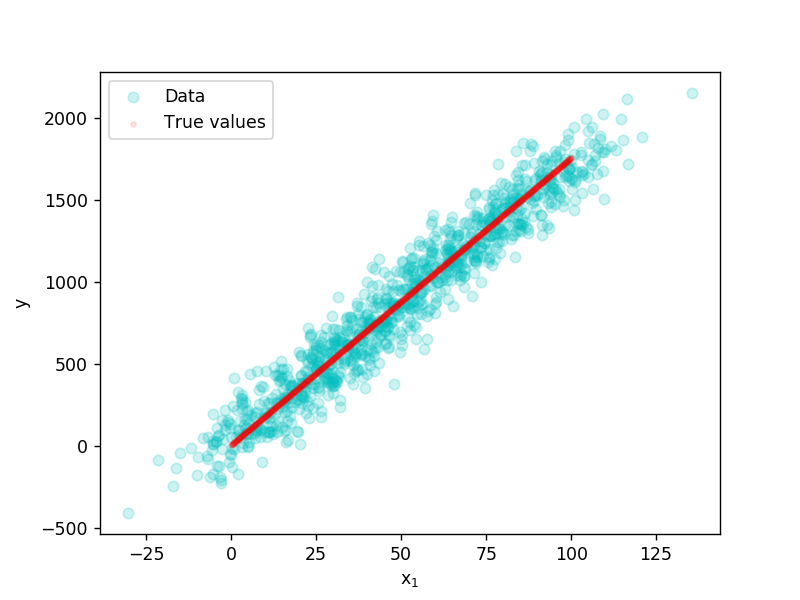

In [15]:
plt.scatter(X1, y, c="c", alpha=0.2, label="Data")
plt.scatter(X1_true, y_true, c="r", alpha=0.1, marker='.', label = "True values")
plt.xlabel("$\mathrm{x_1}$")
plt.ylabel("$\mathrm{y}$")
plt.legend()

OLS is BLUE in this case. Now if we estimate the coefficients by OLS we get $\hat{\beta}_{OLS} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y} $

In [16]:
β_ols = np.linalg.inv((X.T @ X)) @ (X.T @ y)
β_ols

array([ 3.87952321, 10.15069945, -0.5140264 ,  0.2389458 ])

Now under normality of errors, OLS and MLE estimates of the coefficients are asymptotically equal. Let's define an iterative procedure to estimate $\boldsymbol{\beta}$ through MLE and verify that the results are in line with OLS. When errors are normally distributed, we do not need to go through such lengths as the MLE estimator has a closed-form solution. But we simply show how the convergence algorithm works in this simple case. 

Our true parameter values are $$\boldsymbol{\beta} = \begin{bmatrix}
                            \alpha \\
                            \beta_1 \\
                            \beta_2 \\
                            \beta_3
                      \end{bmatrix}  = \begin{bmatrix}
                            10 \\
                            5 \\
                            0.5 \\
                            0.25
                      \end{bmatrix}
                      , \sigma = 100$$
We define a likelihood function, based on $N$ draws of the data $$f\left(\mathbf{y} | \mathbf{X} ; \boldsymbol{\beta}, \sigma^{2}\right)=\prod_{i=1}^{N} f\left(y_{i} | x_i ; \boldsymbol{\beta}, \sigma^{2}\right)$$
where we assume that errors are normally i.i.d, so

$$ f\left(y_{i} | x_i ; \boldsymbol{\beta}, \sigma^{2}\right) = \frac{1}{\sqrt{2 \pi} \sigma} \cdot e^{-\frac{1}{2 \sigma^{2}}\left(y_{i}-x_{i}^{\prime} \boldsymbol{\beta}\right)^{2}} $$

We further define the likelihood function $\mathcal{L}(\boldsymbol{\beta} | \mathbf{y}, \mathbf{X})$ which treats the parameters $\boldsymbol{\beta}$ and $\sigma$ as random and the values $\mathbf{y, X}$ as given. MLE consists in maximising the value of $\mathcal{L}(\boldsymbol{\beta}, \sigma | \mathbf{y}, \mathbf{X})$ by chosing $\boldsymbol{\beta}$ and $\sigma$ optimally. It is easier to work with the log of the likelihood function and this does not affect the maximiser as any monotonically increasing transformation of a function has the same maximiser.

We thus maximise:

$$
\begin{split}
\ln{\mathcal{L}(\boldsymbol{\beta}, \sigma | \mathbf{y}, \mathbf{X})} = & \ell\left(\boldsymbol{\beta}, \sigma | \mathbf{y}, \mathbf{X} \right) \\
        = & -\frac{n}{2} \ln (2 \pi)-\frac{n}{2} \ln \left(\sigma^{2}\right)-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(y_{i}-x_{i}^{\prime} \beta\right)^{2}
\end{split}
$$

And our solution is:

$$
\left( \hat{\beta}_{MLE}, \hat{\sigma}_{MLE} \right) = \underset{\theta, \beta}{\mathrm{argmax}} \left\{ -\frac{n}{2} \ln (2 \pi)-\frac{n}{2} \ln \left(\sigma^{2}\right)-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(y_{i}-x_{i}^{\prime} \beta\right)^{2} \right\}
$$ 

#### 2.2.  Manual coding of the MLE problem

We now turn to coding the problem stated above. We aim to obtain MLE estimates based on the dataset created at the beginning of the Notebook.

We transform the problem into a minimisation one. Minimisation problems are more numerically stable. We will call a Scipy function for our proble: `scipy.optimize.minimize`.

The Scipy `minimize` function provides a vast collection of constrained and unconstrained minimizations algorithms for multivariate scalar functions. The default algorithm `minimize` resorts to when solving an unconstrained optimization problem (like ours) is the [Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm), which is also used by MATLAB and R's optimisation routines. Another popular option is the [Nelder-Mead method](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method), whose robustness to many types of objective functions makes it a very versatile -but slow- algorithm.
You can pass the algorithm you want use as an argument of `minimize`, based on your application.

We will simply use three arguments in our application of `minimize`: 
* The function to be minimised, called the criterion (here $ -\ell\left(\boldsymbol{\beta}, \sigma | \mathbf{y}, \mathbf{X} \right)$)
* An initial guess for the value of the $\beta$ and $\sigma$ parameters
* The data needed to be fed to the criterion

We first encode the criterion below. We need to be careful about the type of arguments taken by this function. Whether the parameters need to be entered as tuples, arrays, or lists is dictated by the how the `minimize` function works.

In [24]:
def negLogLNorm(params, *args):
    '''
    --------------------------------------------------------------------
    Calculate -log(likelihood) using data points "data" and parameters
    "params". 
    The log(likelihood) is calculated based on the assumption that 
    errors are normally distributed. 
    --------------------------------------------------------------------
    
    INPUTS:
    params  =   numpy array with 2 elements: one k*1 vector of beta 
                coefficients (including intercept), and one scalar for 
                sigma
    data    =   numpy array with two elements: one N*1 vector of 
                observations of the dependent variable, and one N*k 
                matrix of observations of the dependent variables     
    
    RETURNS: 
    neg_log_lik_val =   The negative of the log likelihood, using the 
                        assumption that errors are normally distributed
    --------------------------------------------------------------------
    '''
    
    # Fetching parameters and data (note: args and param are tuples)
    b0, b1, b2, b3, sigma = params
    β = np.array([b0, b1, b2, b3])    #Transforming the tuple of coefficients into an Numpy array to be used in matrix multiplication
    y, X = args[0], args[1]
    
    # Calculating bits of the log-likelihood
    E = y - X @ β                     # vector of errors
    SSE = np.square(E).sum()          # sum of squared errors
    N = len(y)                        #sample size
    
    # Define the log likelihood function
    log_likelihood = - (N/2)*np.log(2 * np.pi) - (N/2)*np.log(sigma**2) - (1/(2 * sigma**2))*SSE
    
    neg_log_likelihood = - log_likelihood 
    
    return neg_log_likelihood

We can now use the `minimize` function. We import the `optimize` library under a convenient name, define some initial parameter values (our guesses), and define the data to be used.

In [48]:
import scipy.optimize as opt

β_0 = np.array([0, 0, 0, 0, 1])
data = (y, X)
MLE_results = opt.minimize(negLogLNorm, β_0, args=(data))
MLE_results

      fun: 6029.736609291493
 hess_inv: array([[ 6.39006122e+00, -7.93476791e-02,  5.64541961e-03,
         3.65318135e-04,  6.31672480e+00],
       [-7.93476791e-02,  3.28728812e-02, -1.60092157e-03,
        -1.92394685e-03, -4.99994149e-02],
       [ 5.64541961e-03, -1.60092157e-03,  7.93586866e-05,
         9.23632625e-05,  4.21621132e-03],
       [ 3.65318135e-04, -1.92394685e-03,  9.23632625e-05,
         1.22895583e-04, -1.34338566e-03],
       [ 6.31672480e+00, -4.99994149e-02,  4.21621132e-03,
        -1.34338566e-03,  6.26963110e+00]])
      jac: array([ 0.        , -0.00061035,  0.02075195, -0.02429199,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 813
      nit: 90
     njev: 116
   status: 2
  success: False
        x: array([  3.87943509,  10.15083588,  -0.51398431,   0.23894934,
       100.56431808])

`minimize` returns our estimated parameters (`x`), and much more, as an `OptimizeResult` object. We get the value of the negative log likelihood, Jacobian and Hessian matrices at the solution, whether the optimiser has converged (in our case it hasn't).

As anticipated, the estimated parameters are the same as those found via OLS. Our encoding of MLE has worked.

If you are interested in coding your own optimisation algorithm, the [Quant-Econ MLE lecture](https://lectures.quantecon.org/py/mle.html) has a nice explanation and implementation of the [Newton-Raphson algorithm](https://en.wikipedia.org/wiki/Newton%27s_method).

#### 2.3. Variance-covariance of $\hat{\theta}_{MLE}$

Note that we can easily obtain the variance-covariance matrix of our MLE estimator, as the inverse of the estimated Hessian is reported in the output above. Formally, the variance-covariance matrix of $\hat{\theta}_{MLE}$ is:

$$ \mathrm{var}(\theta) = \left(-E\left[\frac{\partial^{2} \ln \mathcal{L}(\theta)}{\partial \theta \partial \theta^{\prime}}\right]\right)^{-1} $$

We get it as follows:

In [60]:
var = MLE_results.hess_inv
se_alpha = np.sqrt(var[0, 0])
se_beta1 = np.sqrt(var[1, 1])
se_beta2 = np.sqrt(var[2, 2])
se_beta3 = np.sqrt(var[3, 3])
se_sigma = np.sqrt(var[4, 4])

print('SE(alpha) = ', se_alpha,  
      '\nSE(beta_1) =', se_beta1,
      '\nSE(beta_2) =', se_beta2,
      '\nSE(beta_3) =', se_beta3,
      '\nSE(sigma) =', se_sigma)

SE(alpha) =  2.5278570413203267 
SE(beta_1) = 0.18130880053299975 
SE(beta_2) = 0.008908349264499058 
SE(beta_3) = 0.011085828008636438 
SE(sigma) = 2.503923141244637


#### 2.4.  Constrained optimisation with `minimize`

`minimize` is also equipped with optimisation algorithms designed to deal with constrains. Let's say we believe that the intercept $\alpha$ must be between 5 and 6. The `trust-constr` (Trust-Region Constrained algorithm), `L-BFGS-B` (Limited memory BFGS with Box constraints), `TNC` (Truncated Newton, implemented in C), and `SLSQP` (Sequential Least SQuares Programming) methods can handle these constraints. See more information on these methods [here](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html). They are implemented by calling `method='chosenMethod'` as an argument of `minimize`. 

To define our constraint $5 < \alpha < 6$, we actually need to define a system of inequalities over all parameters. For instance

$$\begin{bmatrix}
   5 \\
   1 \\
   1 \\
   1 \\
   1
   \end{bmatrix} \leq
   \begin{bmatrix}
   1 & 0 & 0 & 0 & 0\\
   0 & 0 & 0 & 0 & 0\\
   0 & 0 & 0 & 0 & 0\\
   0 & 0 & 0 & 0 & 0\\
   0 & 0 & 0 & 0 & 0
   \end{bmatrix}
   \begin{bmatrix}
   \alpha \\
   \beta_1 \\
   \beta_2 \\
   \beta_3 \\
   \sigma
   \end{bmatrix} \leq
   \begin{bmatrix}
   6 \\
   1 \\
   1 \\
   1 \\
   1
   \end{bmatrix} $$
                            
Where only the first inequality could be binding.

This is how we implement it:

In [39]:
#Defining the constraint with LinearConstraint
from scipy.optimize import LinearConstraint
cons = LinearConstraint([[1, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0]],
                        [5, 1, 1, 1, 1],
                        [6, 1, 1, 1, 1])

In [40]:
results_cons = opt.minimize(negLogLNorm, β_0, args=(data), method='trust-constr', constraints=[cons])
results_cons

 barrier_parameter: 0.1
 barrier_tolerance: 0.1
          cg_niter: 1000
      cg_stop_cond: 1
            constr: [array([5.06083557, 0.        , 0.        , 0.        , 0.        ])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 384389992.5692965
  constr_violation: 1.0
    execution_time: 1.8173635005950928
               fun: 26746.327580294288
              grad: array([   -8.73290584, -2085.9224878 ,   629.54150391, -3309.01318359,
       -2833.35107633])
               jac: [array([[1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])]
   lagrangian_grad: array([-3.77118720e-02, -2.08592249e+03,  6.29541504e+02, -3.30901318e+03,
       -2.83335108e+03])
           message: 'The maximum number of function evaluations is exceeded.'
            method: 'tr_interior_point'
              nfev: 6006
              nhev: 0
               nit: 1001
             niter: 1001
          

### 3. MLE with 'statsmodels'

It can be painful to code every single aspect of the Maximum Likelihood Estimation. Fortunately, the [`statsmodels`](https://www.statsmodels.org/stable/index.html) packages has an extensive catalogue of tools for statistical inference, including MLE. This package also allows us to generate a much richer set of outputs very easily: confidence intervals, p-statistics, pseudo- R-squared are all generated by default. 

STATA and R users will feel at home with this package as estimations results are presented in a similar way.